# **Lab 5. Tracking**

## Objectives

* Gain a practical understanding of single and multiple-object tracking in videos.
* Visualize the effects of different choices of parameters and/or representations.
* Make the appropriate design choices to solve concrete problems.
* Appreciate the computational complexity of different algorithmic choices.

## Overview

In this lab you will participate in a Tracking challenge organized by the instructors. This lab is divided in two main parts. In the first part you will develop a simple template tracker and submit your results to the challenge drill. In the second part, the Tracking challenge is fully described along its videos and associated data.

## How shall I do it?
* Track the object in online (i.e. just taking into account seen frames and not the whole video).
* Program your own tracker.
    * You **cannot** use external code.
    * You are not allowed to use tracking libraries/modules.
    * If you would like to use an external module ask the instructor.        
* For the Single Object Tracking:
    * You are expected to create a template tracker.
    * Choose your favorite features.
    * Choose your search method.
    * Decide when and how to update your template?
* For the Multiple Object Tracking:
    * You are expected to track the objects by only using the provided data.
    * But you are free to create your own detector.


## Deliverable

**Deadline**: <span style="color:red">P101: 15/03/22 at 23:59h - P102: 16/03/22 at 23:59h</span>

**Submission**:

* The completed Jupyter Notebook with the following characteristics:
    * All cells must have been executed and work, i.e. they should run.
    * Clear commented code cells when necessary.
    * Clean notebook:
        * The running order is top-down.
        * Non-necessary cells must be removed.
    * Reproducible challenge results:
        * The code must produce the same results as your best challenge submission.
* A report with the following contents:
    * A report with your work, including missing codes and answers to the lab questions (analysis of results, influence of parameters, etc). Address all tasks marked as <font color='green'>**TX.**</font>
* Submit a single zip file in the corresponding delivery task in Aula Global. The submitted zip file has to contain your report and your source code (and all files needed to run it, such as images, other dependencies, etc). The lab will be done in groups of two persons, please submit a single file per group.

## Colab Setup

After uploading and unzipping the files in your **Google Drive**, mount them  in **Colab**:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then, find the path to your lab directory and set it up as follows:

In [2]:
LAB5_DIRPATH = '/content/drive/Shareddrives/VIDEO PROC 3.0/LAB5'

Change the execution path to your lab directory path.

In [3]:
import os

os.chdir(LAB5_DIRPATH)

Run the following command to install the needed video packages and its dependencies

In [4]:
!apt install ffmpeg

!pip install scikit-video

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.4 MB/s eta 0:00:00


## Codalab Setup

<font color='green'>**T0**. Using your UPF email account, create a Codalab account at [https://codalab.org/](https://codalab.org/) and register in our [challenge](https://codalab.lisn.upsaclay.fr/competitions/11141). Your team and tracker name must be stated in your report.</font>

## **Part I. Single Object Tracking**

In this part, you will be introduced to basic techniques for creating a single-object tracker.

### 1. Tracking Mario


The task consists of tracking *Mario Bros* in the following video when he is lowering a flag from a green pole. Our inputs are Mario’s video at <span style="color:red"><tt>'videos/mario.mp4'</tt></span> and its initial target, a bounding box with coords ``[606,102,675,199]`` in format ``[x1, y1, x2, y2]``. 

**Visualizing the video**. Let's display the video using Jupyter's API. *Note that this only displays the video in the notebook.*


In [5]:
from utils import display_video

display_video('videos/mario.mp4', width=480, height=360)

**Loading the video**. In this lab, we will use Scikit-Video and Scikit-Image along with OpenCV to perform loading and processing operations.

In [6]:
from skvideo import io as video_io
from skimage import io

videogen = video_io.vreader('videos/mario.mp4')

frames = [frame for frame in videogen]
num_frames = len(frames)

**Displaying the initial target**. Once we load the RGB frames, we can display the initial bounding box ``[606,102,675,199]`` in the first frame and the patch it contains. In the below cell, the initial bounding box ``bb`` is draw in cyan using the function ``draw_boxes`` from the ``tracking`` module.

*NOTE: The provided ``tracking`` module contains the data structures for bounding boxes, detections, and their visualization functions. You should look carefully at them and use them for your trackers.*

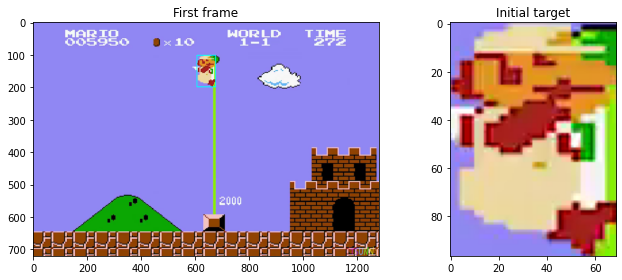

In [7]:
import matplotlib.pyplot as plt

from tracking import BoundingBox
from tracking import draw_boxes

target = BoundingBox([606,102,675,199])

patch = frames[0][target.y1:target.y2, target.x1:target.x2, :]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title("First frame")
ax1.imshow(draw_boxes(frames[0], target, color=(0,255,255)), aspect="auto")
ax2.set_title("Initial target")
ax2.imshow(patch)
fig.tight_layout()
plt.show()

### 2. Target Template Tracking

A template tracker consists of one or more *templates* that represent the target object, a *metric* for comparing them against candidate detections, and a *search algorithm* for finding the best candidates between frames.

#### 2.1. Target Template

In a real-time tracker, the initial target is used as the first template. But as time goes by, different changes might occur to the scene and the target object itself. In consequence, the template could be updated or a new one can be added to the set of templates.

In the problem at hand, we will consider the initial given target as our single template for the whole video, but it is still necessary to define a proper representation and its associated metric.

#### 2.2. Appearance-based tracking

One straightforward representation could be using the RGB pixels of our template. For comparing our *image template*, we can use the *mean squared error* ($MSE$) between two images $I_{1}$ and $I_{2}$, defined as:

$$MSE(I_{1}, I_{2})=\frac{1}{|N|}\sum_{(i,j)\in N}\big(I_{1}(i,j)-I_{2}(i,j)\big)^{2}$$

where $N$ denotes the neighborhood pixel coordinates, and $|N|$ the number of pixels in the neighborhood. Another metric is the *sum of absolute differences* ($SAD$) defined as:

$$SAD(I_{1}, I_{2})=\sum_{(i,j)\in N}\big|I_{1}(i,j)-I_{2}(i,j)\big|$$

Both metrics are closer to $0$ when both images are more similar.

<font color='green'>**T1. Comparing the appearance using the MSE metric**. Use the ``mean_squared_error`` function defined in ``skimage.metrics`` to compare 2 patches at frame $i=4$ with respect to our RGB ``template``. The bounding boxes are defined by ``[590, 92, 659, 189]`` and ``[601, 137, 670, 234]``.

<font color='green'>&#9679;&ensp;In a single figure using ``plt.subplots``, plot the template, patch1, and patch2.

<font color='green'>&#9679;&ensp;Determine the two resulting MSE values and state which patch is more similar to the template.

<font color='green'>&#9679;&ensp;What values are expected for very similar and not similar patches using the MSE?

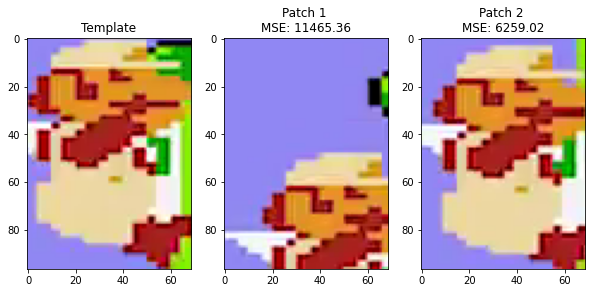

In [8]:
from skimage.metrics import mean_squared_error

# Defining our RGB template from the initial target
template = frames[0][target.y1:target.y2, target.x1:target.x2, :]
frame = frames[4]

# Cogemos dos patches del frame i=4
boundingbox1 = BoundingBox([590, 92, 659, 189])
patch1 = frame[boundingbox1.y1:boundingbox1.y2, boundingbox1.x1:boundingbox1.x2, :]

boundingbox2 = BoundingBox([601, 137, 670, 234])
patch2 = frame[boundingbox2.y1:boundingbox2.y2, boundingbox2.x1:boundingbox2.x2, :]

# Calculamos el MSE de los dos patches
mse1 = mean_squared_error(template, patch1)
mse2 = mean_squared_error(template, patch2)

# Hacemos los plots de las figuras

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.set_title("Template")
ax1.imshow(template)
ax2.set_title(f'Patch 1 \nMSE: {mse1:0.2f}')
ax2.imshow(patch1)
ax3.set_title(f'Patch 2 \nMSE: {mse2:0.2f}')
ax3.imshow(patch2)
plt.show()

#### 2.2. Histogram-based tracking

Another useful representation is calculating the histogram of the template. Tipically, the histograms are taken from any color space (RGB, HSV, CMYK, etc.) and from all or different selected channels. In our case, we will use all the RGB channels and spliting them in a grid of (8, 8, 8), thus having a histogram with a dimension 512 or bins. A way to visualize the grid over the RGB color space is looking at the following figure showing the RGB color cube with a tridimensional grid of (6,6,6).

<img src="https://raw.githubusercontent.com/gorayni/lab5/main/RGB_color_solid_cube.png" alt="Sliding Window" width="300px"/>

Although we lose the spatial characteristics of the appearance template, histogram templates can be more flexible when comparing candidate targets of different sizes.

We can achieve better histogram measurements by considering them as probability distributions rather than simple value vectors. In addition, there are distinct metrics to measure two probability distributions $p$ and $q$, for example, the Kullback-Leibler divergence defined as:

$$D_{\mathrm{KL}}(p\|q) = \sum_x p(x) \ln \frac{p(x)}{q(x)}$$

Or the Bhattacharyya distance:

$$D_B(p,q) = -\ln \left( \sum_{x\in X} \sqrt{p(x) q(x)} \right)$$

<font color='green'>**T2. Comparing histograms using the Bhattacharyya distance**. Compare the histograms of 2 patches at frame $i=30$ with respect to the histogram of our RGB ``template``. The bounding boxes of the two patches are defined by ``[606,102,675,199]`` and ``[601, 507, 670, 604]``. First, compute the histograms using the ``calculate_patch_hist`` function defined in the file ``regions.py``. Then, calculate the Bhattacharyya distance using the ``bhattacharyya_dist`` wrapper function defined in the file ``regions.py``

<font color='green'>&#9679;&ensp;In a single figure using ``plt.subplots``, plot the template, patch1, and patch2.

<font color='green'>&#9679;&ensp;In a single figure using ``plt.subplots``, plot the histograms of the template, patch1, and patch2.

<font color='green'>&#9679;&ensp;Determine the two resulting Bhattacharyya distance values and state which patch is more similar to the template.

<font color='green'>&#9679;&ensp;What values are expected for very similar and not similar patches using the Bhattacharyya distance?

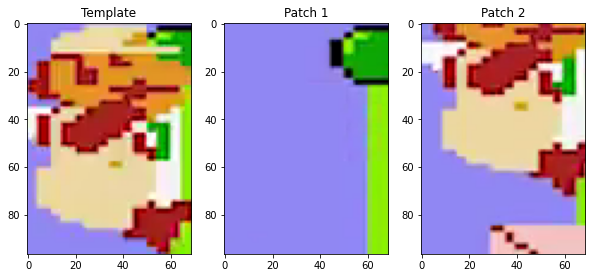

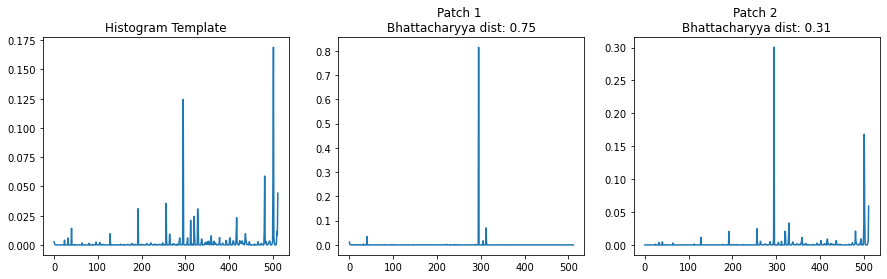

In [9]:
from regions import bhattacharyya_dist
from regions import calculate_patch_hist

# Definimos el histograma del template del primer frame
hist_template = calculate_patch_hist(frames[0], target)
frame = frames[30]

# Cogemos dos patches del frame i=30
boundingbox3 = BoundingBox([606,102,675,199])
patch1 = frame[boundingbox3.y1:boundingbox3.y2, boundingbox3.x1:boundingbox3.x2, :]

boundingbox4 = BoundingBox([601, 507, 670, 604])
patch2 = frame[boundingbox4.y1:boundingbox4.y2, boundingbox4.x1:boundingbox4.x2, :]

# Cogemos dos patches del frame i=30 y calculamos el histograma
patch1_hist = calculate_patch_hist(frame, boundingbox3)
patch2_hist = calculate_patch_hist(frame, boundingbox4)

# Calculamos la Bhattacharyya distance de los dos pacthes con el template
dist1 = bhattacharyya_dist(hist_template, patch1_hist)
dist2 = bhattacharyya_dist(hist_template, patch2_hist)

# Hacemos los plots de las figuras
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.set_title("Template")
ax1.imshow(template)
ax2.set_title(f'Patch 1')
ax2.imshow(patch1)
ax3.set_title(f'Patch 2')
ax3.imshow(patch2)
plt.show()

# Hacemos el plot de los histogramas
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.set_title("Histogram Template")
ax1.plot(hist_template)
ax2.set_title(f'Patch 1 \nBhattacharyya dist: {dist1:0.2f}')
ax2.plot(patch1_hist)
ax3.set_title(f'Patch 2 \nBhattacharyya dist: {dist2:0.2f}')
ax3.plot(patch2_hist)
plt.show()

#### 2.3. Sliding Window Search

A basic search algorithm involves generating candidates by performing a sliding window in the current frame near the neighborhood of the previous detection. For example, lets suppose that the next couple of frames are consecutive:

<div style="display:inline-block;text-align: center;">
Frame $i-1$<br>
<img src="https://raw.githubusercontent.com/gorayni/lab5/main/mario_00.png" alt="Frame i-1" width="400px"/>
</div>
<div style="display:inline-block;text-align: center;">
Frame $i$<br>
<img src="https://raw.githubusercontent.com/gorayni/lab5/main/mario_05.png" alt="Frame i" width="400px"/>
</div>
<div style="clear:both;"></div>

Then a sliding window search could generate a set of candidates from frame $i$ like follows:

<img src="https://raw.githubusercontent.com/gorayni/lab5/main/sliding_window.gif" alt="Sliding Window" width="300px"/>

Where the red bounding box represents the <span style="color:red">original detection</span> at frame $i-1$, the blue rectangle is the <span style="color:blue">search area or neighborhood</span>, and each green bounding box contains a <span style="color:green">detection candidate</span>. Other possible search algorithms could be based on physics or by predicting according to the trajectory of the tracked objects like particle filtering algorithms.

<font color='green'>**T3. Sliding window**. The purpose of the next ``sliding_window`` function is to return all the possible bounding boxes (``bboxes``) inside a search area in an image with respect to the centroid of a given bounding box ``bb``. All the resulting bounding boxes have the same size as the input bounding box ``bb``. Consider that the search area must be inside the frame and that is defined as shown in the next figure.

<div style="display:inline-block;text-align: center;">
<img src="https://raw.githubusercontent.com/gorayni/lab5/main/search_area.png" alt="Search Area" width="300px"/>
</div>

Num. bounding boxes: 57500


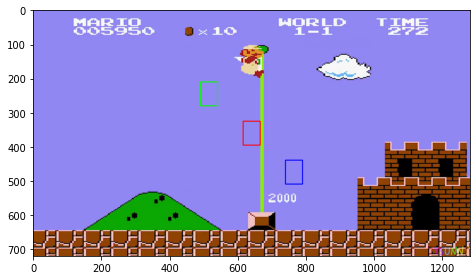

Num. bounding boxes: 14375


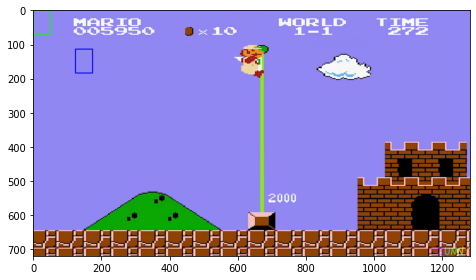

Num. bounding boxes: 14616


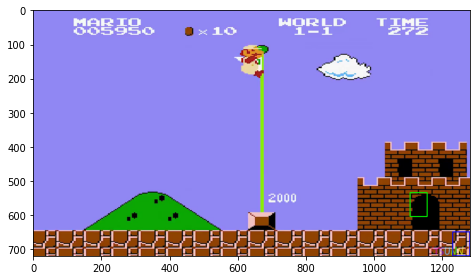

In [10]:
import numpy as np
from itertools import product


def sliding_window(bb, frame_shape, area_size):
    
    centroid = bb.centroid()
    width, height = bb.size()    
    ######################### COMPLETE THIS FUNCTION ##########################
   
    start_x = int(centroid[0] - area_size[0]//2)
    end_x = int(centroid[0] + area_size[0]//2 - width)
    start_y = int(centroid[1] - area_size[1]//2)
    end_y = int(centroid[1] + area_size[1]//2 - height)
    
    if start_x < 0:
      start_x = 0
    if end_x + width > frame_shape[0]:
      end_x = frame_shape[0] - width
    if start_y < 0:
      start_y = 0
    if end_y + height > frame_shape[1]:
      end_y = frame_shape[1] - height  

    
    ###########################################################################
    bboxes = []
    for x, y in product(range(start_x, end_x), range(start_y, end_y)):
        bboxes.append(BoundingBox([x, y, x + width, y + height]))
    return bboxes


height, width = frames[0].shape[0:2]
frame_shape = (width, height)

area_shape = (300, 300)

bb = BoundingBox([615, 325,665, 395])
center_bboxes = sliding_window(bb, frame_shape, area_shape)
print(f'Num. bounding boxes: {len(center_bboxes)}')

img = draw_boxes(frames[0], bb, color=(255,0,0))
img = draw_boxes(img, center_bboxes[0], color=(0,255,0))
img = draw_boxes(img, center_bboxes[-1], color=(0,0,255))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.imshow(img)
fig.tight_layout()
plt.show()



bb = BoundingBox([0,0,50,70])
top_left_corner_bboxes = sliding_window(bb, frame_shape, area_shape)
print(f'Num. bounding boxes: {len(top_left_corner_bboxes)}')

img = draw_boxes(frames[0], bb, color=(255,0,0))
img = draw_boxes(img, top_left_corner_bboxes[0], color=(0,255,0))
img = draw_boxes(img, top_left_corner_bboxes[-1], color=(0,0,255))
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.imshow(img)
fig.tight_layout()
plt.show()


bb = BoundingBox([1229,649,1279,719])
bottom_right_corner_bboxes = sliding_window(bb, frame_shape, area_shape)
print(f'Num. bounding boxes: {len(bottom_right_corner_bboxes)}')


img = draw_boxes(frames[0], bb, color=(255,0,0))
img = draw_boxes(img, bottom_right_corner_bboxes[0], color=(0,255,0))
img = draw_boxes(img, bottom_right_corner_bboxes[-1], color=(0,0,255))
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.imshow(img)
fig.tight_layout()
plt.show()

<font color='green'>**T4. Build a template tracker**. The following code forms the skeleton of a template tracker. Adapt the ``sliding_window`` to complete the ``search_neighborhood`` function using an appearance or histogram template.</font>

<font color='green'>NOTE 1: The provided ``DetectionBox`` extends the ``BoundingBox`` by adding an attribute ``id_`` representing the identity of the tracked object. For the single object tracking case this value must be 1.</font>

<font color='green'>NOTE 2: The functions at the ``tracking`` and ``utils`` modules depend on a dictionary of ``detections`` where its ``keys`` represent frame indices and its ``values`` are lists of ``DetectionBox`` objects.</font>

In [11]:
import numpy as np
from itertools import product
from tracking import DetectionBox

def search_neighborhood(frame, prev_detection, hist_template, search_area_shape):
        
    ######################### COMPLETE THIS FUNCTION ##########################

    bboxes = sliding_window(prev_detection, frame.shape, search_area_shape)

    #inicialitzem els valors de min_dist i best_candidate
    min_dist = np.inf
    best_candidate = None
    
    #recorrem la bb neighborhood
    for i in range(len(bboxes)):
      #calculem l'histograma entre el frame i la bb
      hist = calculate_patch_hist(frame, bboxes[i])
      #Calculem la distancia de Bhattacharyya l'histograma del template i del bb
      dist_hist = bhattacharyya_dist(hist_template, hist)
      
      #comparem la distancia amb la distancia minima i anem actualitzant el valor
      if dist_hist <= min_dist:
        best_candidate = bboxes[i]
        min_dist = dist_hist
    
    ###########################################################################
    return DetectionBox(1, best_candidate)


def track_single_object(frames, target, search_area_shape):        
    # Initializing the detections data structure
    detections = {frame_idx: [] for frame_idx in range(num_frames)}

    # Setting the first detection
    detections[0].append(DetectionBox(1, target))
    #fixed_template = frames[0][target.y1:target.y2, target.x1:target.x2, :]
    hist_template = calculate_patch_hist(frames[0], target)
    for idx in range(1, len(frames)):
        current_frame = frames[idx]
        previous_detection = detections[idx-1][0]
        detections[idx].append(search_neighborhood(current_frame, previous_detection, hist_template, search_area_shape))
    return detections

detections = track_single_object(frames, target, (100,140))

**Visualizing the tracking results**. You can visualize your tracking results in a single frame using the <tt>draw_detections</tt> function as follows:

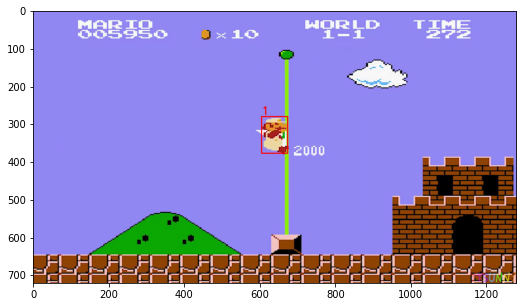

In [12]:
from tracking import draw_detections

fig = plt.figure(figsize=(9,5))
plt.imshow(draw_detections(frames[15], detections[15]))
plt.show()

Another way of visualization is to creating a video using all the frames using the <tt>draw_tracks</tt> function:

In [13]:
from tracking import draw_tracks

tracked_frames = draw_tracks(frames, detections, font_scale=0.6, thickness=2, frame_id_color=(0,0,0))

with video_io.FFmpegWriter("tracked_mario.mp4", outputdict={'-pix_fmt': 'yuv420p'}) as writer:
    for i in range(len(tracked_frames)):
        writer.writeFrame(tracked_frames[i])
        
display_video('tracked_mario.mp4', width=480, height=360)

**Saving tracking results**. A way of saving the tracking results is:

In [14]:
np.save("mario_tracking_results.npy", detections)

FUNCTIONS


In [15]:
def sliding_window(bb, frame_shape, area_size):
  centroid = bb.centroid()
  width, height = bb.size()    

  start_x = int(np.maximum(centroid[0]-area_size[0]/2,0));
  end_x = int(np.minimum(centroid[0]+area_size[0]/2-width,frame_shape[0]-width-1));
  start_y = int(np.maximum(centroid[1]-area_size[1]/2,0));
  end_y = int(np.minimum(centroid[1]+area_size[1]/2-height,frame_shape[1]-height-1));
  
  bboxes = []
  for x, y in product(range(start_x, end_x), range(start_y, end_y)):
      bboxes.append(BoundingBox([x, y, x + width, y + height]))
  return bboxes

import cv2

def search_neighborhood(frame, prev_detection, template, search_area_shape):
        
    ######################### COMPLETE THIS FUNCTION ##########################

    height, width = frame.shape[0:2]
    frame_shape = (width, height)    
    bboxes = sliding_window(prev_detection, frame_shape, search_area_shape)
        
    hist_template = cv2.calcHist([template], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist_template = hist_template.flatten() / hist_template.sum()


    #inicialitzem els valors de min_dist i best_candidate
    min_dist = np.inf
    best_candidate = None
    
    #recorrem la bb neighborhood
    for i in range(len(bboxes)):
      #calculem l'histograma entre el frame i la bb
      hist = calculate_patch_hist(frame, bboxes[i])
      #Calculem la distancia de Bhattacharyya l'histograma del template i del bb
      dist_hist = bhattacharyya_dist(hist_template, hist)
      
      #comparem la distancia amb la distancia minima i anem actualitzant el valor
      if dist_hist <= min_dist:
        best_candidate = bboxes[i]
        min_dist = dist_hist
    
    ###########################################################################
    return DetectionBox(1, best_candidate)


def track_single_object(frames, target, search_area_shape):        
    # Initializing the detections data structure
    detections = {frame_idx: [] for frame_idx in range(num_frames)}

    # Setting the first detection
    detections[0].append(DetectionBox(1, target))
    fixed_template = frames[0][target.y1:target.y2, target.x1:target.x2, :]
    #hist_template = calculate_patch_hist(frames[0], target)
    for idx in range(1, len(frames)):
        current_frame = frames[idx]
        previous_detection = detections[idx-1][0]
        detections[idx].append(search_neighborhood(current_frame, previous_detection, fixed_template, search_area_shape))
    return detections

RACE

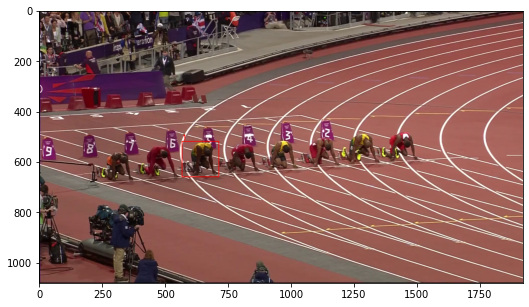

In [16]:
videogen = video_io.vreader('videos/race.mp4')

frames = [frame for frame in videogen]
num_frames = len(frames)

target = BoundingBox([567,517,713,658])

detections = track_single_object(frames[1:len(frames)], target, (200,200))
fig = plt.figure(figsize=(9,5))
plt.imshow(draw_detections(frames[2], detections[2]))
plt.show()


In [17]:
from tracking import draw_tracks

tracked_frames = draw_tracks(frames, detections, font_scale=0.6, thickness=2, frame_id_color=(0,0,0))

with video_io.FFmpegWriter("tracked_race.mp4", outputdict={'-pix_fmt': 'yuv420p'}) as writer:
    for i in range(len(tracked_frames)):
        writer.writeFrame(tracked_frames[i])
        
display_video('tracked_race.mp4', width=480, height=360)

np.save("race_tracking_results.npy", detections)

MEGAMAN

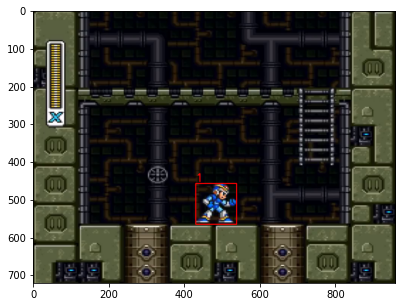

In [18]:
videogen = video_io.vreader('videos/megaman.mp4')

frames = [frame for frame in videogen]
num_frames = len(frames)

target = BoundingBox([430,454,538,562])
detections = track_single_object(frames[1:466], target, (200,200))

fig = plt.figure(figsize=(9,5))
plt.imshow(draw_detections(frames[2], detections[2]))
plt.show()

In [19]:
from tracking import draw_tracks

tracked_frames = draw_tracks(frames, detections, font_scale=0.6, thickness=2, frame_id_color=(0,0,0))

with video_io.FFmpegWriter("tracked_megaman.mp4", outputdict={'-pix_fmt': 'yuv420p'}) as writer:
    for i in range(len(tracked_frames)):
        writer.writeFrame(tracked_frames[i])
        
display_video('tracked_megaman.mp4', width=480, height=360)

np.save("megaman_tracking_results.npy", detections)

MOTORCYCLE

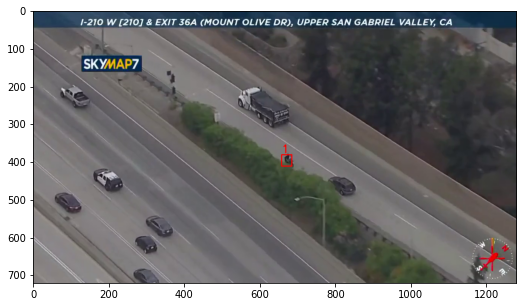

In [20]:
videogen = video_io.vreader('videos/motorcycle.mp4')

frames = [frame for frame in videogen]
num_frames = len(frames)

target = BoundingBox([665,378,692,408])

detections = track_single_object(frames[1:len(frames)], target, (200,200))
fig = plt.figure(figsize=(9,5))
plt.imshow(draw_detections(frames[2], detections[2]))
plt.show()

In [21]:
from tracking import draw_tracks

tracked_frames = draw_tracks(frames, detections, font_scale=0.6, thickness=2, frame_id_color=(0,0,0))

with video_io.FFmpegWriter("tracked_motorcycle.mp4", outputdict={'-pix_fmt': 'yuv420p'}) as writer:
    for i in range(len(tracked_frames)):
        writer.writeFrame(tracked_frames[i])
        
display_video('tracked_motorcycle.mp4', width=480, height=360)

np.save("motorcycle_tracking_results.npy", detections)

## **Part II. Multiple Object Tracking**

In this part, you will be introduced to basic techniques for creating a multiple object tracker (MOT).

### 1. Tracking Tennis Players


The task consists of tracking all the people in a *Tennis* game. Our inputs are the tennis video at <span style="color:red"><tt>'videos/tennis.mp4'</tt></span> and the bounding boxes of all detected people. 

**Visualizing the video**. Let's display the video using Jupyter's API.


In [22]:
from utils import display_video

display_video('videos/tennis.mp4', width=480, height=360)

**Loading the video**. Let's load its frames.

In [23]:
from skvideo import io as video_io
from skimage import io

videogen = video_io.vreader('videos/tennis.mp4')

frames = [frame for frame in videogen]
num_frames = len(frames)

**Loading the semantic segmentation data**. We provide you with the semantic segmentation of all the people for all the frames. The semantic segmentation was extracted using a Deep Learning method named [PointRend](https://arxiv.org/abs/1912.08193). In the following cell we load the bounding boxes and masks for all the frames in the video that have a confidence score > 80%.

In [24]:
from utils import load_semantic_segmentation

bboxes, masks = load_semantic_segmentation('semantic_segmentation/tennis.npy', 0.8)

**Visualizing the semantic segmentation**. In the following cell we plot the bounding boxes of all segmented people for the first frame.

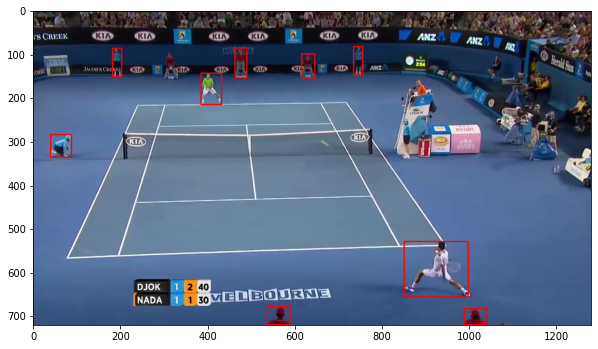

In [25]:
import matplotlib.pyplot as plt
from tracking import draw_boxes

frame_id = 0
fig = plt.figure(figsize=(10,6))
plt.imshow(draw_boxes(frames[frame_id], bboxes[frame_id], color=(255,0,0)))
plt.show()

**OPTIONAL**: Although **is not necessary for this lab**, you can create better tracking methods using the segmentation mask of the objects. You can use the mask as follows:

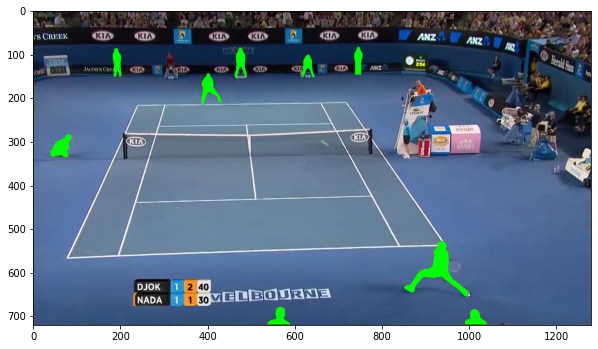

In [26]:
from skimage.draw import polygon
import numpy as np

frame = np.copy(frames[frame_id])
green_color = np.asarray([0, 255, 0])

for bb, mask_contours in zip(bboxes[frame_id], masks[frame_id]):
    patch = frame[bb.y1:bb.y2, bb.x1:bb.x2, :]
    for cnt in mask_contours:
        rr, cc = polygon(cnt[:, 1], cnt[:, 0])
        patch[rr, cc, :] = green_color
    
fig = plt.figure(figsize=(10,6))
plt.imshow(frame)
plt.show()

Our first step for building a MOT tracker will be assigning an arbitrary ID to our bounding boxes in our *previous* frame. In this example, the ID of our previous frame should be $i=0$.

In [27]:
from tracking import DetectionBox

previous_frame_id = 0
previous_frame = frames[previous_frame_id]
previous_detections = []

for id_, bb in enumerate(bboxes[previous_frame_id]):
    previous_detections.append(DetectionBox(id_, bb))

**Visualizing the frames to match**. In the following tasks, we will assume that our **next frame is $i=40$**. The next cell shows the detected bounding boxes with their corresponding ID for the first frame and the next frame with its red bounding boxes.

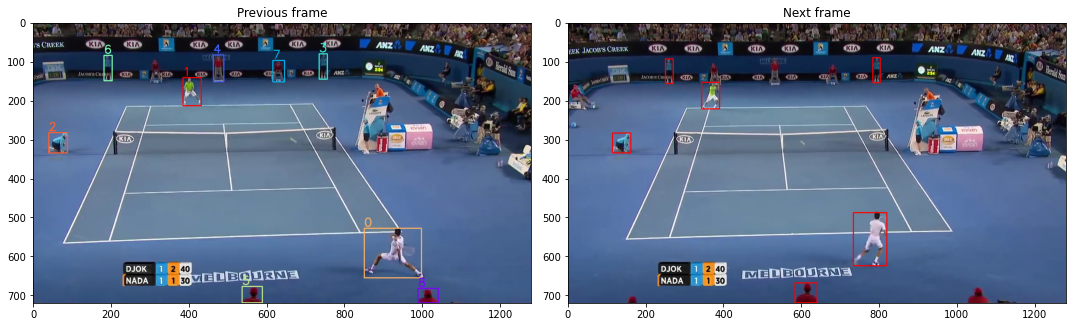

In [28]:
import matplotlib.pyplot as plt
from tracking import draw_detections

next_frame_id = 40
next_frame = frames[next_frame_id]
next_bboxes = bboxes[next_frame_id]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.set_title("Previous frame")
ax1.imshow(draw_detections(previous_frame, previous_detections))
ax2.set_title("Next frame")
ax2.imshow(draw_boxes(next_frame, next_bboxes))
fig.tight_layout()
plt.show()


The second step for creating our MOT tracker is creating a similarity matrix that tell us how similar are all the detected objects in the *next frame* w.r.t. to each detected object in the *previous frame*.

<font color='green'>**T5. Similarity matrix**. A simple similarity matrix will only take into account the distance between bounding boxes. Complete the ``calculate_distance_matrix`` function in the following cell. The input of this function are the detected bounding boxes from the previous frame and the bounding boxes from the next frame. Each element in the matrix is the Euclidean distance in pixels between the centroids of the bounding boxes.

In [29]:
from itertools import product
from numpy import linalg as LA
import math

def calculate_distance_matrix(prev_bboxes, next_bboxes):

    prev_centroids = [bb.centroid() for bb in prev_bboxes]
    num_prev_centroids = len(prev_centroids)
    next_centroids = [bb.centroid() for bb in next_bboxes]
    num_next_centroids = len(next_centroids)
    distances = np.zeros((num_prev_centroids, num_next_centroids))
    
    ######################### COMPLETE THIS FUNCTION ##########################
    
    #calcular la distancia de cada prev por cada next
    for i in range(0,num_prev_centroids):
        for j in range(0,num_next_centroids):
            cent = prev_centroids[i]
            centr = next_centroids[j]
            distances[i,j] = math.sqrt(((centr[0]-cent[0])**2)+((centr[1]-cent[1])**2))
    
    ###########################################################################
    
    return distances

distance_matrix = calculate_distance_matrix(previous_detections, next_bboxes)


<font color='green'>**T6. Similarity matrix**. In the next cell, the values of the non-square distance matrix are plot. 

<font color='green'>&#9679;&ensp;What does it mean that an element of the matrix has a small value?
    
<font color='green'>&#9679;&ensp;What does it mean that an element of the matrix has a large value?

<font color='green'>&#9679;&ensp;State the possible causes of having less bounding boxes in the next frame.

<font color='green'>&#9679;&ensp;How does it affects the multiple-object tracking?

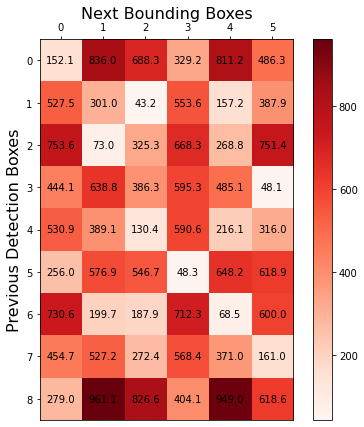

In [30]:
from utils import plot_similarity_matrix
    
plot_similarity_matrix(distance_matrix, figsize=(7,7))

The last step of our MOT is to match the previous detections with the predictions in the next frame.

<font color='green'>**T7. Matching bounding boxes and IDs assignation**. Complete the ``calculate_matches`` function in the following cell. You can use a greedy approach or the Hungarian algorithm.

In [31]:
from scipy.optimize import linear_sum_assignment 

def calculate_matches(similarity_matrix):
    matches = []
    
    ######################### COMPLETE THIS FUNCTION ##########################

    #Hungarian algorithm 
    fila_i, columna_i = linear_sum_assignment(similarity_matrix)
    
    for i in range(0,len(fila_i)): 
      matches.append((fila_i[i],columna_i[i]))

    ###########################################################################    
    return matches

matches = calculate_matches(distance_matrix)

# ID ASSIGNATION
next_detections = []
for (i,j) in matches:
    prev_detection_id = previous_detections[i].id_
    next_bbox = next_bboxes[j]
    
    next_detection = DetectionBox(prev_detection_id, next_bbox)
    next_detections.append(next_detection)

**Visualizing the matches**. The following cell shows the matched boxes for both frames.

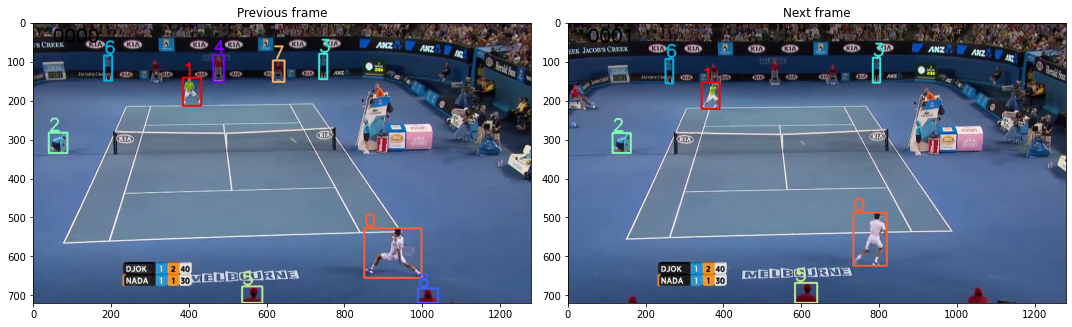

In [32]:
from tracking import draw_tracks

tracked_frames = draw_tracks([previous_frame, next_frame], {0: previous_detections, 1: next_detections}, font_scale=1.5, thickness=3, frame_id_color=(0,0,0))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.set_title("Previous frame")
ax1.imshow(tracked_frames[0])
ax2.set_title("Next frame")
ax2.imshow(tracked_frames[1])
fig.tight_layout()
plt.show()

<font color='green'>**T8. Build a distance MOT tracker**. The following code forms the skeleton of a distance MOT tracker. Use the ``calculate_distance_matrix`` and ``calculate_matches`` functions to complete the ``track_multiple_object`` function.</font>

In [33]:
import numpy as np
from itertools import product


def track_multiple_objects(bboxes):
    
    num_frames = len(bboxes)
    
    # Initializing the detections data structure
    detections = {frame_idx: [] for frame_idx in range(num_frames)}
        
    # Assigning arbitrary IDs to the bounding boxes of the first frame
    frame_idx = 0
    for i, bb in enumerate(bboxes[frame_idx]):
        detections[frame_idx].append(DetectionBox(i, bb))
    
    ######################### COMPLETE THIS FUNCTION ##########################
        
    previous_detections = detections[frame_idx]
     
    for i in range(1,num_frames):
        
        next_bboxes = bboxes[i]
        distance_matrix = calculate_distance_matrix(previous_detections, next_bboxes)    
        matches = calculate_matches(distance_matrix)   
 
        # ID ASSIGNATION
        
        next_detections = []

        for (j,k) in matches:
            prev_detection_id = previous_detections[j].id_
            next_bbox = next_bboxes[k]

            next_detection = DetectionBox(prev_detection_id, next_bbox)
            next_detections.append(next_detection)
        
        detections[i] = next_detections
     

    ###########################################################################
    return detections



detections = track_multiple_objects(bboxes)

**Visualizing the tracking results**. You can visualize your tracking results in a single frame using the <tt>draw_detections</tt> function as follows:

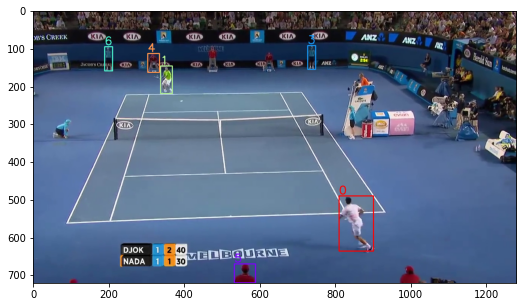

In [34]:
from tracking import draw_detections

fig = plt.figure(figsize=(9,5))
plt.imshow(draw_detections(frames[15], detections[15]))
plt.show()

Another way of visualization is to creating a video using all the frames using the <tt>draw_tracks</tt> function:

In [35]:
from tracking import draw_tracks

tracked_frames = draw_tracks(frames, detections, font_scale=0.6, thickness=2, frame_id_color=(0,0,0))

with video_io.FFmpegWriter("tracked_tennis.mp4", outputdict={'-pix_fmt': 'yuv420p'}) as writer:
    for i in range(len(tracked_frames)):
        writer.writeFrame(tracked_frames[i])
        
display_video('tracked_tennis.mp4', width=480, height=360)

## **Part III. Codalab Tracking Mini-Challenge**

In this part we provide an overview of the tracking challenge. The task of the challenge is to track single and multiple objects from the video data.

We describe the videos and associated data, briefly present the evaluation metrics, and give general guidelines for your submissions.

### 1. Videos and Data Description

The challenge is composed of 5 videos from different settings and divided in two broad categories: 3 for single object tracking (SOT) and 2 for multiple object tracking (MOT). The data was manually labeled so perfect results are not expected.

#### 1.1 Single Object Tracking

For these videos we only provide the initial target box as specified in the following table:

| Videoname           | Target Object            | Initial Target Bounding box | Video location        | Number of frames | First frame |
| ------------------- | ------------------------ | --------------------------- | --------------------- | ---------------- | ----------- |
| <tt>megaman</tt>  | Megaman (blue android)  | ``[430,454,538,562]``       | videos/megaman.mp4  | 600              | <img src="https://raw.githubusercontent.com/gorayni/lab5/main/first_frame_megaman.png" alt="videogame" width="300px"/> |
| <tt>race</tt>     | Fastest Racer | ``[567,517,713,658]``       | videos/racer.mp4     | 426              |<img src="https://raw.githubusercontent.com/gorayni/lab5/main/first_frame_race.png" alt="tennis" width="300px"/> |
| <tt>motorcycle</tt> | Chased Motorist                      | ``[665,378,692,408]``       | videos/motorcycle.mp4 | 600              |<img src="https://raw.githubusercontent.com/gorayni/lab5/main/first_frame_motorcycle.png" alt="single_ant" width="300px"/> |

#### 1.2 Multiple Object Tracking

For these videos we provide a semantic segmentation results using a Deep Learning method named [PointRend](https://arxiv.org/abs/1912.08193). These results only include the segmentation for the class *Person*. The description and data location appear in the next table:


| Videoname           | Target Object            | Segmentation location              | Video location        | Number of frames | First frame |
| ------------------- | ------------------------ | ---------------------------------- | --------------------- | ---------------- | ----------- |
| <tt>football</tt>   | People in the field      | semantic_segmentation/football.npy | videos/football.mp4  | 503             |<img src="https://raw.githubusercontent.com/gorayni/lab5/main/first_frame_football_2.png" alt="football" width="300px"/> |
| <tt>pedestrians</tt>   | Pedestrians crossing      | semantic_segmentation/pedestrians.npy | videos/pedestrians.mp4  | 179             |<img src="https://raw.githubusercontent.com/gorayni/lab5/main/first_frame_pedestrians_2.png" alt="pedestrians" width="300px"/> |

You are not expected to create the detection for your MOT tracker as a semantic segmentation is provided to you.

### 2. Evaluation Metrics

We will use the Higher Order Tracking Accuracy (HOTA) family metrics to measure the tracking performance introduced [here](https://arxiv.org/abs/2009.07736). Specifically, the four main metrics that the challenge board considers in order of importance are: HOTA, detection (DetA), association (LocA), and localization (LocA). The challenge board only considers the mean performance of the 5 videos. An individual performance summary for each video is offered in the output summary detailed in the last section of Part 1. Moreover, the summary present the evaluation for all the HOTA metrics. The next figure taken from this [link](https://towardsdatascience.com/better-quantifying-the-performance-of-object-detection-in-video-c21d5b16493c?utm_source=pocket_mylist) shows the hierarchy of the HOTA metrics:

<img src="https://raw.githubusercontent.com/gorayni/lab5/main/hota_metrics.jpeg" alt="HOTA Metrics" width="500px"/>

For more information you can consult the original paper or these couple of links by [Cameron Wolfe](https://towardsdatascience.com/better-quantifying-the-performance-of-object-detection-in-video-c21d5b16493c?utm_source=pocket_mylist) and [Jonathon Luiten](https://autonomousvision.github.io/hota-metrics/?utm_source=pocket_mylist).

### 3. General Guidelines

* The ``tracking_results`` for the ``create_submission`` function follows this structure:

```python
tracking_results = {'football': {0: [DetectionBox(...), DetectionBox(...)],
                                   .
                                   .
                                   .
                                 502: [DetectionBox(...), DetectionBox(...)],},
                    'megaman': {0: [DetectionBox(...)],
                                   .
                                   .
                                   .
                                 599: [DetectionBox(...)]}
                     .
                     .
                     .
                     }
```
where the only valid key values are <span style="color:red"><tt>'mario'</tt></span>, <span style="color:red"><tt>'megaman'</tt></span>, <span style="color:red"><tt>'race'</tt></span>, <span style="color:red"><tt>'motorcycle'</tt></span>, <span style="color:red"><tt>'football'</tt></span>, and <span style="color:red"><tt>'pedestrians'</tt></span>.

* Keep a single ``tracker_name`` for all your results submissions. This can be the name of your team.

* **Consider that the results directory is removed when a new submission is created with the ``create_submission`` function**. While working on different videos, you can save preliminary results from one video using ``numpy`` ``save`` and ``load`` functions.

### 4. Codalab Drill Submission

**Create a submission**. After obtaining your tracking results you need to define a <tt>tracker_name</tt> and wrap your <tt>detections</tt> in a dictionary where the key is the videoname and the value its tracking results. 

The next cell will create directory containing the tracking results name <tt>'results'</tt> and zipped submission file:

**Submit your results**. Go to the Codalab challenge site and submit the created zip file in the **Participate > Submit/View Results > Submit**, as shown in the next figure:

<img src="https://raw.githubusercontent.com/gorayni/lab5/main/drill_submission_2023.png" alt="Drill submission" width="420px"/>

**Inspect your results**. After your submission has been processed with no problems, you can download a detailed summary of your results by:

    a) Clicking the plus button in the list of your submissions:
    
<img src="https://raw.githubusercontent.com/gorayni/lab5/main/submission_results_a.png" alt="Submission results a" width="520px"/>

    b) Downloading the scoring output log:
    
<img src="https://raw.githubusercontent.com/gorayni/lab5/main/submission_results_b.png" alt="Submission results b" width="520px"/>

**Check the challenge board**. You can see the challenge board by clicking **Results > Challenge**, as shown in the next figure:

<img src="https://raw.githubusercontent.com/gorayni/lab5/main/challenge_board_2023.png" alt="Challenge board" width="600px"/>

<font color='green'>**T9. Create a Single-Object Tracker for <tt>megaman</tt>, <tt>race</tt>, and <tt>motorcycle</tt> videos**. You are not expected to build one tracker for each individual video and it is highly recommended to use a single function for all of them that receives different parameters. You can reuse the skeleton created in T4. In your report clearly state:</font>

* <font color='green'>The name of your team and tracker name in the challenge.</font>
* <font color='green'>For each video clearly describe:</font>
    * <font color='green'>The algorithm design used on it.</font>
    * <font color='green'>The influence of the parameters.</font>
    * <font color='green'>An explanation of the features used by your algorithm.</font>
    * <font color='green'>An analysis describing its strong points and pitfalls.</font>
* <font color='green'>Provide a comparison between the results of the three videos.</font>
* <font color='green'>An interpretation of the obtained challenge results metrics (HOTA) for all videos.</font>


<font color='green'>**T10. Create a Multiple-Object Tracker for <tt>football</tt> and <tt>pedestrian</tt> videos.** You are not expected to build one tracker for each individual video and it is highly recommended to use a single function for all of them that receives different parameters. In your report clearly state</font>

* <font color='green'>The name of your team and tracker name in the challenge.</font>
* <font color='green'>For each video clearly describe:</font>
    * <font color='green'>The algorithm design used on it.</font>
    * <font color='green'>The influence of the parameters.</font>
    * <font color='green'>An explanation of the features used by your algorithm.</font>
    * <font color='green'>An analysis describing its strong points and pitfalls.</font>
* <font color='green'>Provide a comparison between the results of both videos.</font>
* <font color='green'>An interpretation of the obtained challenge results metrics (HOTA) for all videos.</font>

PEDESTRIAN

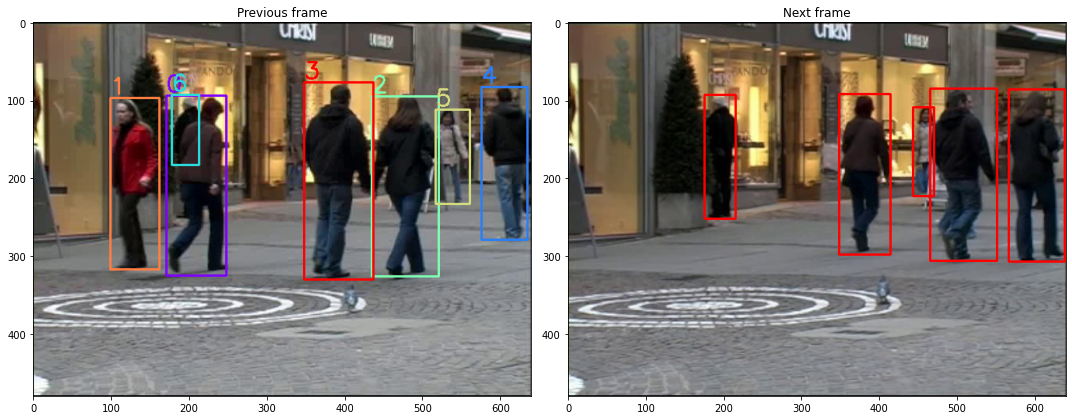

In [36]:
from skvideo import io as video_io
from skimage import io
import matplotlib.pyplot as plt
from tracking import draw_detections
from tracking import DetectionBox

#LOAD
videogen = video_io.vreader('videos/pedestrians.mp4')

frames = [frame for frame in videogen]
num_frames = len(frames)

#SEMANTIC SEGMENTATION
bboxes, masks = load_semantic_segmentation('semantic_segmentation/pedestrians.npy', 0.8)


#INITIAL ID
previous_frame_id = 0
previous_frame = frames[previous_frame_id]
previous_detections = []

for id_, bb in enumerate(bboxes[previous_frame_id]):
    previous_detections.append(DetectionBox(id_, bb))
    
#VISUALIZATION
next_frame_id = 40
next_frame = frames[next_frame_id]
next_bboxes = bboxes[next_frame_id]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.set_title("Previous frame")
ax1.imshow(draw_detections(previous_frame, previous_detections))
ax2.set_title("Next frame")
ax2.imshow(draw_boxes(next_frame, next_bboxes))
fig.tight_layout()
plt.show()




In [37]:
from tracking import draw_tracks

#DETECTIONS
detections = track_multiple_objects(bboxes)

#SAVE
np.save("pedestrian_tracking_results.npy", detections)

#VISUALIZATION
tracked_frames = draw_tracks(frames, detections, font_scale=0.6, thickness=2, frame_id_color=(0,0,0))

with video_io.FFmpegWriter("tracked_pedestrians.mp4", outputdict={'-pix_fmt': 'yuv420p'}) as writer:
    for i in range(len(tracked_frames)):
        writer.writeFrame(tracked_frames[i])
        
display_video('tracked_pedestrians.mp4', width=480, height=360)

FOOTBALL



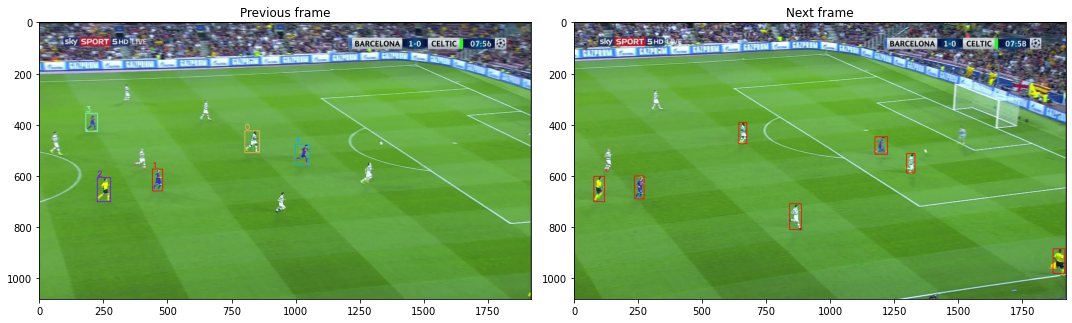

In [38]:
from skvideo import io as video_io
from skimage import io
import matplotlib.pyplot as plt
from tracking import draw_detections
from tracking import DetectionBox

#LOAD
videogen = video_io.vreader('videos/football.mp4')

frames = [frame for frame in videogen]
num_frames = len(frames)

#SEMANTIC SEGMENTATION
bboxes, masks = load_semantic_segmentation('semantic_segmentation/football.npy', 0.8)


#ID
previous_frame_id = 0
previous_frame = frames[previous_frame_id]
previous_detections = []

for id_, bb in enumerate(bboxes[previous_frame_id]):
    previous_detections.append(DetectionBox(id_, bb))
    
#VISUALIZATION
next_frame_id = 40
next_frame = frames[next_frame_id]
next_bboxes = bboxes[next_frame_id]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.set_title("Previous frame")
ax1.imshow(draw_detections(previous_frame, previous_detections))
ax2.set_title("Next frame")
ax2.imshow(draw_boxes(next_frame, next_bboxes))
fig.tight_layout()
plt.show()




In [39]:
from tracking import draw_tracks

#DETECTIONS
detections = track_multiple_objects(bboxes)

#SAVE
np.save("football_tracking_results.npy", detections)

#VISUALIZATION
tracked_frames = draw_tracks(frames, detections, font_scale=0.6, thickness=2, frame_id_color=(0,0,0))

with video_io.FFmpegWriter("tracked_football.mp4", outputdict={'-pix_fmt': 'yuv420p'}) as writer:
    for i in range(len(tracked_frames)):
        writer.writeFrame(tracked_frames[i])
        
display_video('tracked_football.mp4', width=480, height=360)

Output hidden; open in https://colab.research.google.com to view.

### ------ SUBMISSIONS -------








In [40]:
from utils import create_submission
import numpy as np


tracker_name = "M_A_P"

# Loading Mario's previously tracked results
detections = np.load('mario_tracking_results.npy', allow_pickle=True).item()
detections2 = np.load('race_tracking_results.npy', allow_pickle=True).item()
detections3 = np.load('megaman_tracking_results.npy', allow_pickle=True).item()
detections4 = np.load('motorcycle_tracking_results.npy', allow_pickle=True).item()
detections5 = np.load('pedestrian_tracking_results.npy', allow_pickle=True).item()
detections6 = np.load('football_tracking_results.npy', allow_pickle=True).item()

tracking_results = {'mario': detections,
                    'megaman': detections3,
                    'race': detections2,
                    'motorcycle': detections4,
                    'football': detections6,
                    'pedestrians': detections5}
create_submission(tracking_results, tracker_name, results_dir='results')